In [1]:
import geopandas
import numpy
import numpy
import math
import shapely
import matplotlib.pyplot as plt
from shapely.geometry import polygon   

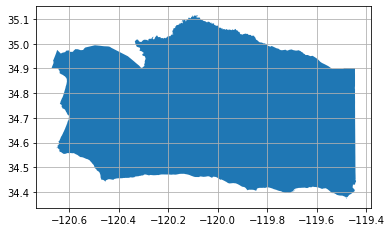

In [111]:
fig, ax = plt.subplots()
ax.grid(True)

caribbean = geopandas.read_file('../data/caribbean.gpkg') 
polygons = caribbean[caribbean['NAME_0'] =='Trinidad and Tobago']

polygons = geopandas.read_file('../data/santa_barbara.gpkg') 
#polygons = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#polygons = polygons[polygons.name =='Brazil']


polygons.plot(ax=ax)

In [112]:
geom_type = polygons.iloc[0].geometry.type
if  geom_type == 'Polygon':
    # We drop the last point because it is a repetition of the first point
    lon = polygons.iloc[0].geometry.exterior.xy[0]
    lat = polygons.iloc[0].geometry.exterior.xy[1]
elif geom_type == 'MultiPolygon':
    lon = []
    lat = []
    for p in list(polygons.iloc[0].geometry):
        lon += polygon.orient(p).exterior.xy[0]
        lat += polygon.orient(p).exterior.xy[1]

# Dirty trick to get rid of duplicate points
#lat, lon = zip(*(set(zip(lat, lon))))

lat, lon = zip(*list(dict.fromkeys(zip(lat, lon))))
len(lat)

#lon, lat = polygons.geometry.iloc[0][0].exterior.xy

5115

In [113]:
lon = numpy.array(lon)
lat = numpy.array(lat)

# We convert to ECEF vectors
x = numpy.cos(lon/360*math.pi*2) * numpy.cos(lat/360*math.pi*2)
y = numpy.sin(lon/360*math.pi*2) * numpy.cos(lat/360*math.pi*2)
z = numpy.sin(lat/360*math.pi*2)

# We create a nx3 matrix of the points 
nodes = numpy.array([x, y, z]).transpose()

n = len(x)

In [114]:
def test_edge(from_index, to_index):
    gc = numpy.cross(nodes[from_index], nodes[to_index])
    good = True
    for node_index in range(len(nodes)):          
        if node_index == from_index or node_index == to_index:
            continue
        if numpy.dot(nodes[node_index], gc) < 0:
            good = False
            break            
    return good


def find_first_from_index():
    for from_index in range(1, len(nodes)-1):
        if test_edge(from_index, from_index+1):
            return from_index, from_index+1
            break

In [115]:
a, b = find_first_from_index()
print(a, b)

5026 5027


In [103]:
print(nodes[a])
print(nodes[b])

[ 0.48300385 -0.8534313   0.19586297]
[ 0.48300292 -0.85342965  0.19587245]


# Linear script

In [104]:
def insert_node(node_index):
    
    # Nothing to do if point is already in set of convex hull nodes
    if node_index in convex_nodes:
        return convex_nodes
    
    # Nothing to do if a node of same location as the point is already in convex
    for node in convex_nodes:
        if numpy.array_equal(nodes[node_index], nodes[node]):
            return convex_nodes
    
    # What is the first constraint outside which our point lies?
    insertion = -1
    for edge_index in range(len(edges)):
        direction = numpy.dot(edges[edge_index], nodes[node_index])
        if  direction < 0:
            insertion = edge_index
            break
    
    # If the point is inside all constraints, it can be discarded
    if insertion == -1:
        return convex_nodes
        
    # Otherwise we insert the point in the gap between 
    # the nodes that define the constraint outside which the point lies
    convex_nodes.insert(insertion+1, node_index)
    
    # We create a new edge from the starting point of the gap to the inserted point
    gc = numpy.cross(nodes[convex_nodes[insertion]], nodes[convex_nodes[insertion+1]])
    edges[insertion] = gc
    
    # Now we test if the new node makes successive nodes obsolete 
    # We don't need to test backwards since the new node would have been inserted in the gap before
    direction = 1
    while direction >= 0:
        from_index = (insertion+1)%len(convex_nodes) 
        to_index   = (insertion+3)%len(convex_nodes)
        test_index = (insertion+2)%len(convex_nodes)
        new_arc = numpy.cross(nodes[convex_nodes[from_index]], nodes[convex_nodes[to_index]])
        direction = numpy.dot(new_arc, nodes[convex_nodes[test_index]])
        if direction >= 0:
            convex_nodes.pop(test_index)
            edges.pop(test_index-1)
    
    # We create an edge from the newly inserted node to its next neigbor 
    # (i.e. the one for which the briding test failed)
    gc =  numpy.cross(nodes[convex_nodes[from_index]], nodes[convex_nodes[test_index]])
    edges.insert(insertion+1, gc)
    return convex_nodes

In [105]:
convex_nodes = []
convex_nodes.append(a)
convex_nodes.append(b)
edges = []
edges.append(numpy.cross(nodes[a], nodes[b]))
edges.append(numpy.cross(nodes[b], nodes[a]))

[array([-8.41620706e-06, -4.76319586e-06,  0.00000000e+00]), array([8.41620706e-06, 4.76319586e-06, 0.00000000e+00])]


In [106]:
for i in range(len(nodes)):
    insert_node(i)

# Object Oriented

In [107]:
class ConvexEdge:
    
    def __init__(self, from_node=None, to_node=None):
        self.from_node = from_node
        self.to_node = to_node
        self.gc = numpy.cross(self.from_node, self.to_node)
        
    def from_indices(self, from_index, to_index, nodes):
        self.from_node = nodes[from_index]
        self.to_node = nodes[to_index]
        self.gc = numpy.cross(self.from_node, self.to_node)
        
    def node_outside(self, node):
        direction = numpy.dot(self.gc, node)
        if direction < 0:            
            return True
        else: 
            return False
        
class CircularList:
    
    def __init__(self):
        self.elements = []
        
    def get(self, index):
        loop_index = index % len(self.elements)
        return self.elements[loop_index]
    
    def pop(self, index):
        loop_index = index % len(self.elements)
        self.elements.pop(loop_index)
        
    def append(self, element):
        self.elements.append(element)
    
    def insert(self, index, element):
        loop_index = index % len(self.elements)
        self.elements.insert(index, element)
        
    def len(self):
        return len(self.elements)


class ConvexHull:
    
    def __init__(self, node1, node2):
        self.edges = CircularList()
        self.edges.append(ConvexEdge(node1, node2))
        self.edges.append(ConvexEdge(node2, node1))
           
    def nodes(self):
        nodes = []
        for edge in self.edges.elements:            
            nodes.append(edge.from_node)
        return nodes
    
    def insert_node(self, node):
        if self.node_already_in_hull(node):
            return -1
        
        insertion_edge_index = self.find_insertion_edge_index(node)
        if insertion_edge_index == -1:
            return -1
        
        self.pop_nodes(insertion_edge_index)
        self.span_new_nodes(insertion_edge_index)
        
    def pop_nodes(self, insertion_edge_index):
        self.edges.pop(insertion_edge_index)
        while self.edges.get(insertion_edge_index).node_outside(node):
            self.edges.pop(insertion_edge_index)
        
    def span_new_nodes(self, insertion_edge_index):
        previous_node = self.edges.get(insertion_edge_index-1).to_node
        next_node = self.edges.get(insertion_edge_index).from_node
        new_edge_1 = ConvexEdge(from_node=previous_node, to_node=node)
        new_edge_2 = ConvexEdge(from_node=node, to_node=next_node)
        self.edges.insert(insertion_edge_index, new_edge_2)
        self.edges.insert(insertion_edge_index, new_edge_1)  
    
    def node_already_in_hull(self, insert_node):
        for node in self.nodes():
            if numpy.array_equal(node, insert_node):
                return True
        return False

    def find_insertion_edge(self, node):
        for edge in self.edges.elements:
            if edge.node_outside(node):
                return edge
        return -1   
    
    def find_insertion_edge_index(self, node):
        for edge_index in range(self.edges.len()):
            edge = self.edges.get(edge_index)
            if edge.node_outside(node):
                return edge_index
        return -1

In [108]:
ch = ConvexHull(nodes[a], nodes[b])

for node in nodes:
    ch.insert_node(node)

In [109]:
for convex_node in ch.nodes():
    print(numpy.where(nodes==numpy.array(convex_node[0]))[0][0])

101
102
378
268
269
312
1765
2161
17976
17991
17994
7929
7931
7933
7934
7936
7942
7944
7963
7971
7984
7991
8001
8009
8010
10565
10759
11705
11722


# Visualization

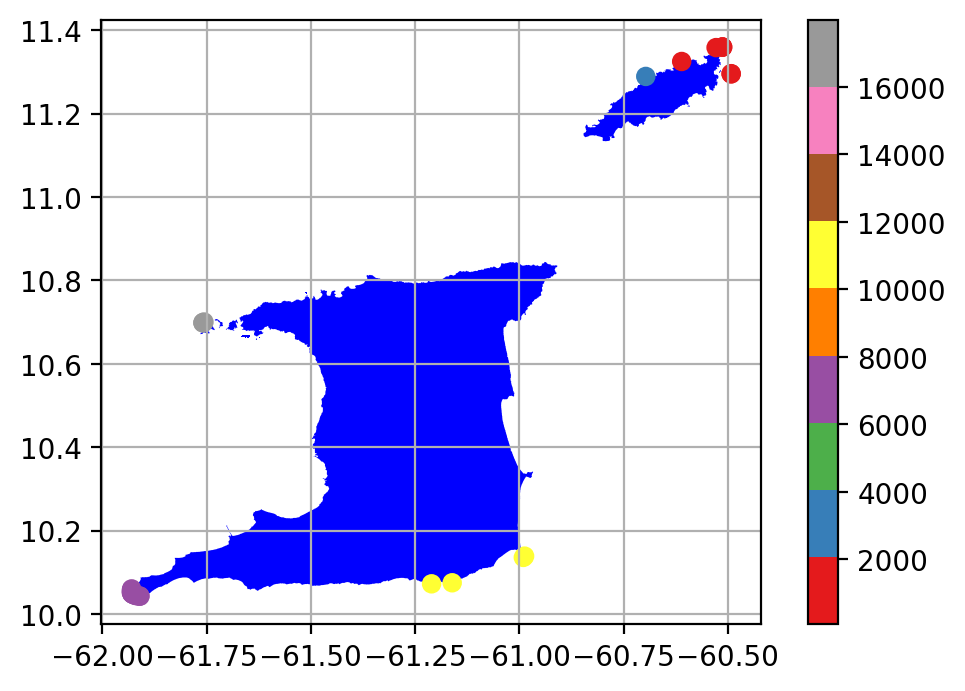

In [110]:
fig, ax = plt.subplots(dpi=200)
ax.grid(True)

polygons.plot(ax=ax, color='b')

points = []

for node_index in convex_nodes:
    points.append(shapely.geometry.Point([lon[node_index], lat[node_index]]))
    
points = geopandas.GeoDataFrame({'edges': points, 'id':convex_nodes}).set_geometry('edges')
points.plot(ax=ax,  column='id', legend=True, cmap='Set1')